<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by <a href="https://gitlab.com/AkashNarayanan" target="_blank"> AkashNarayanan B</a></td>    
</table>
<hr>

So far we have learned how to use the Ocean SDK tools. Now let's use those tools to formulate Binary Quadratic Models for some combinatorial optimization problems. In this notebook, we will learn how to formulate BQM for the Maximum Cut problem.

# BQM Formulation of the Maximum Cut Problem

To briefly recall, the goal of the maximum cut problem is to partition a set of vertices of a graph into two disjoint sets such that the number of edges that are cut by the partition is maximized.

The QUBO objective function for a graph with edge set E is 

$$\min \sum_{(i, j) \in E} (-x_i - x_j + 2x_ix_j)$$

The Ising objective function for a graph with edge set E is

$$\min \sum_{(i, j) \in E} s_i s_j$$

`dwave-networkx` package in the Ocean SDK has implementations of graph-theory algorithms for some combinatorial optimization problems like Maximum Cut, Graph Colouring, Traveling Salesman, etc. You can find out more details about the available algorithms [here](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/algorithms/index.html).

We can either use these already implemented algorithms or solve by formulating the problem as a QUBO or Ising Model from scratch. We will look at both the ways this problem can be solved.

# Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import dimod
from dimod.reference.samplers import ExactSolver
from collections import defaultdict

%run bqm_functions.py

Let's try to solve the following graph in both ways.

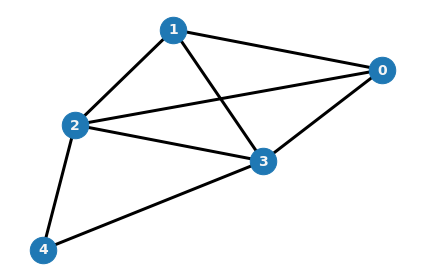

In [2]:
G = nx.house_x_graph()
# nx.draw(G, with_labels=True)
graph_viz(G)

# Built-in Function

`maximum_cut` is the built-in function in the `dwave-networkx` package for solving the maximum cut problem.

## Parameters

- `G` - The NetworkX graph
- `sampler` - BQM sampler for solving the NetworkX graph

We are going the use the classical solver `ExactSolver()` for solving this problem.

In [3]:
sampler = ExactSolver()

cut = dnx.maximum_cut(G, sampler)
print(cut)

{2, 3}


## Visualizing the Result

The built-in function returns a set of nodes that produce the maximum cut. It is helpful to visualize the output.

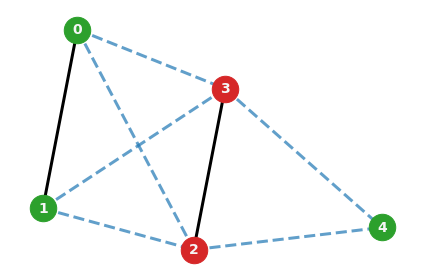

In [4]:
S0 = [node for node in G.nodes if node in cut]
S1 = [node for node in G.nodes if node not in cut]

cut_edges = [(u, v) for u, v in G.edges if (u in S0 and v not in S0) or (u in S1 and v not in S1)]
uncut_edges = [(u, v) for u, v in G.edges if (u in S0 and v in S0) or (u in S1 and v in S1)]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color="tab:red", node_size=700)
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color="tab:green", node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashed', edge_color="tab:blue", alpha=0.7, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold', font_color="whitesmoke")

plt.tight_layout()
plt.axis("off")
plt.show()

For ease of use we can define a function `maxcut_viz()` to resuse the above code with some generalization. The function can be accessed in the `bqm_functions.py` file.

## Parameters

- `G` - The NetworkX graph
- `cut_nodes` - A set/dictionary of the nodes obtained as the output 

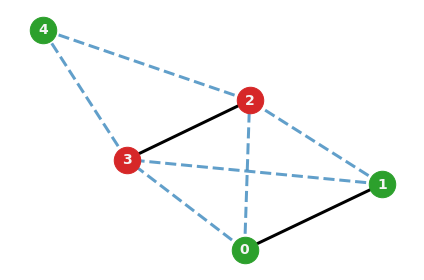

In [6]:
maxcut_viz(G, cut)

## Task 1

Find the maximum cut for the following graph using the built-in function and visualize the result.

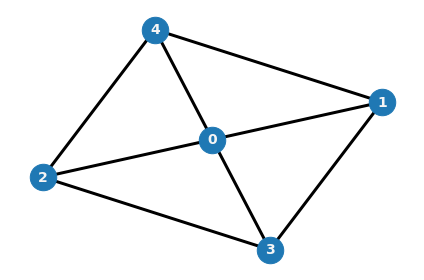

In [7]:
G1 = nx.turan_graph(5, 3)
#nx.draw(G1, with_labels=True)
graph_viz(G1)

[Click Here for Solution](BQM_MaxCut_Solution.ipynb#Task-1)

Now let's learn how to solve the problem by formulating the QUBO and Ising Model from scratch.

# Formulating QUBO from Scratch

## Step - 1

Define the QUBO in dictionary form using the objective function

$$\min \sum_{(i, j) \in E} (-x_i - x_j + 2x_ix_j)$$

In [8]:
Q = defaultdict(int)

for i, j in G.edges:
    Q[(i, i)] += -1
    Q[(j, j)] += -1
    Q[(i, j)] += 2

print(Q)

defaultdict(<class 'int'>, {(0, 0): -3, (1, 1): -3, (0, 1): 2, (2, 2): -4, (0, 2): 2, (3, 3): -4, (0, 3): 2, (1, 2): 2, (1, 3): 2, (2, 3): 2, (4, 4): -2, (2, 4): 2, (3, 4): 2})


## Step - 2

Create an instance of BQM from the QUBO dictionary and solve it using `ExactSolver()`.

In [9]:
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

sampler = ExactSolver()
sampleset = sampler.sample(bqm)

print(sampleset)

    0  1  2  3  4 energy num_oc.
8   0  0  1  1  0   -6.0       1
29  1  1  0  0  1   -6.0       1
4   0  1  1  0  0   -5.0       1
6   1  0  1  0  0   -5.0       1
9   1  0  1  1  0   -5.0       1
11  0  1  1  1  0   -5.0       1
12  0  1  0  1  0   -5.0       1
14  1  0  0  1  0   -5.0       1
17  1  0  0  1  1   -5.0       1
19  0  1  0  1  1   -5.0       1
25  1  0  1  0  1   -5.0       1
27  0  1  1  0  1   -5.0       1
28  0  1  0  0  1   -5.0       1
30  1  0  0  0  1   -5.0       1
2   1  1  0  0  0   -4.0       1
5   1  1  1  0  0   -4.0       1
7   0  0  1  0  0   -4.0       1
13  1  1  0  1  0   -4.0       1
15  0  0  0  1  0   -4.0       1
16  0  0  0  1  1   -4.0       1
18  1  1  0  1  1   -4.0       1
23  0  0  1  1  1   -4.0       1
24  0  0  1  0  1   -4.0       1
26  1  1  1  0  1   -4.0       1
1   1  0  0  0  0   -3.0       1
3   0  1  0  0  0   -3.0       1
20  0  1  1  1  1   -3.0       1
22  1  0  1  1  1   -3.0       1
10  1  1  1  1  0   -2.0       1
31  0  0  

If necessary, we can inspect the QUBO matrix.

In [10]:
matrix = bqm.to_numpy_matrix()
print(matrix)

[[-3.  2.  2.  2.  0.]
 [ 0. -3.  2.  2.  0.]
 [ 0.  0. -4.  2.  2.]
 [ 0.  0.  0. -4.  2.]
 [ 0.  0.  0.  0. -2.]]


/tmp/ipykernel_19938/207217293.py:1: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0
  matrix = bqm.to_numpy_matrix()


## Step - 3

Obtain the optimum sample from the sampleset and visualize the result.

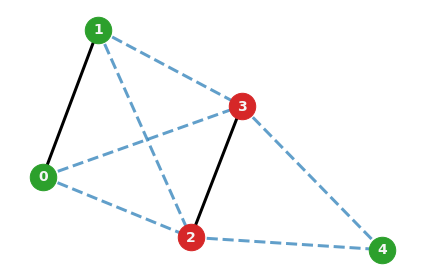

In [13]:
os = sampleset.first.sample

maxcut_viz(G, os)

## Task 2

Obtain the maximum cut for the following graph

1. Define the QUBO dictionary
2. Create an instance of BQM from the dictionary and solve it using the classical solver
3. Visualize the output obtained from the sampleset

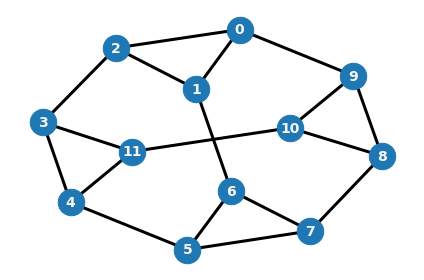

In [14]:
G2 = nx.truncated_tetrahedron_graph()
#nx.draw(G, with_labels=True)
graph_viz(G2)

[Click Here for Solution](BQM_MaxCut_Solution.ipynb#Task-2)

# Formulating Ising from Scratch

For formulating an Ising model for the problem the code used to populate the dictionary should be altered according to the Ising objective function. The remaining steps would be the same.

## Step - 1

Define the Ising Model in dictionary form using the objective function

$$\min \sum_{(i, j) \in E} s_i s_j$$

In [15]:
h = defaultdict(int)
J = defaultdict(int)

for i, j in G.edges:
    J[(i, j)] += 1

print(f"h = {h}")
print(f"J = {J}")

h = defaultdict(<class 'int'>, {})
J = defaultdict(<class 'int'>, {(0, 1): 1, (0, 2): 1, (0, 3): 1, (1, 2): 1, (1, 3): 1, (2, 3): 1, (2, 4): 1, (3, 4): 1})


## Step - 2

Create an instance of BQM from the dictionaries `h` and `J` and solve it using `ExactSolver()`.

In [16]:
bqm = dimod.BinaryQuadraticModel.from_ising(h, J)

sampler = ExactSolver()
sampleset = sampler.sample(bqm)

print(sampleset)

    0  1  2  3  4 energy num_oc.
8  -1 -1 +1 +1 -1   -4.0       1
29 +1 +1 -1 -1 +1   -4.0       1
4  -1 +1 +1 -1 -1   -2.0       1
6  +1 -1 +1 -1 -1   -2.0       1
9  +1 -1 +1 +1 -1   -2.0       1
11 -1 +1 +1 +1 -1   -2.0       1
12 -1 +1 -1 +1 -1   -2.0       1
14 +1 -1 -1 +1 -1   -2.0       1
17 +1 -1 -1 +1 +1   -2.0       1
19 -1 +1 -1 +1 +1   -2.0       1
25 +1 -1 +1 -1 +1   -2.0       1
27 -1 +1 +1 -1 +1   -2.0       1
28 -1 +1 -1 -1 +1   -2.0       1
30 +1 -1 -1 -1 +1   -2.0       1
2  +1 +1 -1 -1 -1    0.0       1
5  +1 +1 +1 -1 -1    0.0       1
7  -1 -1 +1 -1 -1    0.0       1
13 +1 +1 -1 +1 -1    0.0       1
15 -1 -1 -1 +1 -1    0.0       1
16 -1 -1 -1 +1 +1    0.0       1
18 +1 +1 -1 +1 +1    0.0       1
23 -1 -1 +1 +1 +1    0.0       1
24 -1 -1 +1 -1 +1    0.0       1
26 +1 +1 +1 -1 +1    0.0       1
1  +1 -1 -1 -1 -1    2.0       1
3  -1 +1 -1 -1 -1    2.0       1
20 -1 +1 +1 +1 +1    2.0       1
22 +1 -1 +1 +1 +1    2.0       1
10 +1 +1 +1 +1 -1    4.0       1
31 -1 -1 -

## Step - 3

Obtain the optimum sample from the sampleset and visualize the result.

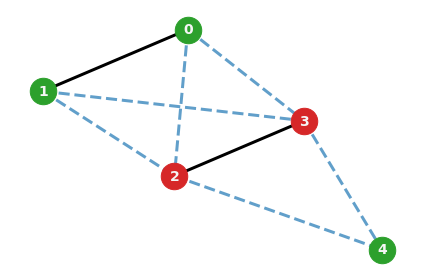

In [17]:
os = sampleset.first.sample

maxcut_viz(G, os)

## Task 3

Obtain the maximum cut for the following graph

1. Define the dictionaries `h` and `J`
2. Create an instance of BQM from the dictionaries and solve it using the classical solver
3. Visualize the output obtained from the sampleset

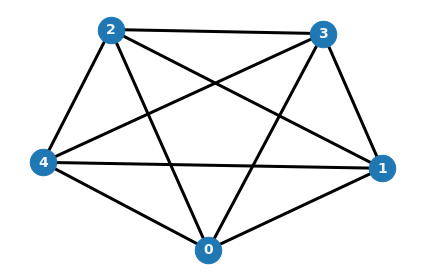

In [18]:
#G3 = nx.Graph()
#G3.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 5), (3, 5), (3, 4), (4, 5)])

G3 = nx.complete_graph(5)

graph_viz(G3)

[Click Here for Solution](BQM_MaxCut_Solution.ipynb#Task-3)

# References

1. F. Glover, G. Kochenberger and Y. Du. "Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models," [arXiv:1811.11538v6](https://arxiv.org/abs/1811.11538v6), 2019.

2. ["Maximum Cut"](https://github.com/dwave-examples/maximum-cut),  D-Wave Systems Examples, accessed November 2021.